<a href="https://colab.research.google.com/github/hilalongel/DSA-210-project/blob/main/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving final_exploded_boxoffice_with_genres_and_seasons.csv to final_exploded_boxoffice_with_genres_and_seasons (2).csv
 Model Evaluation:
MAE: 60.29
RMSE: 89.09
R² Score: 0.7107


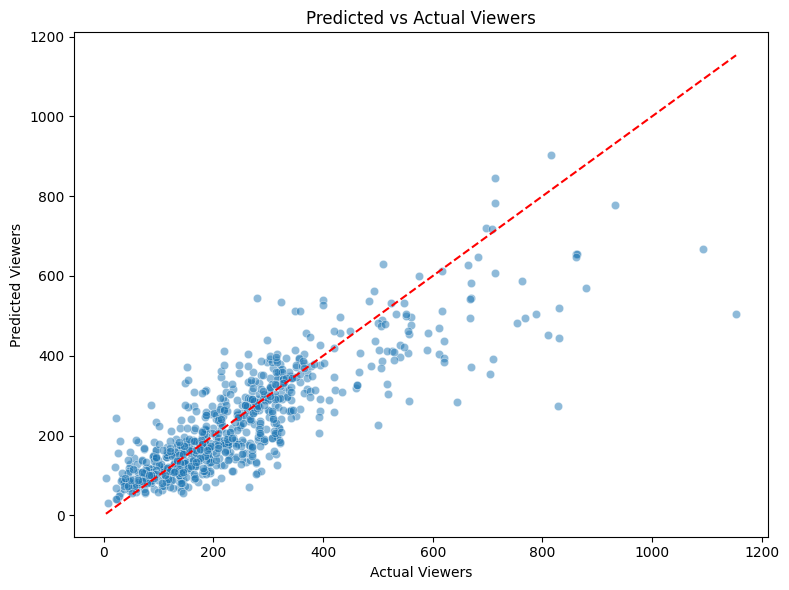

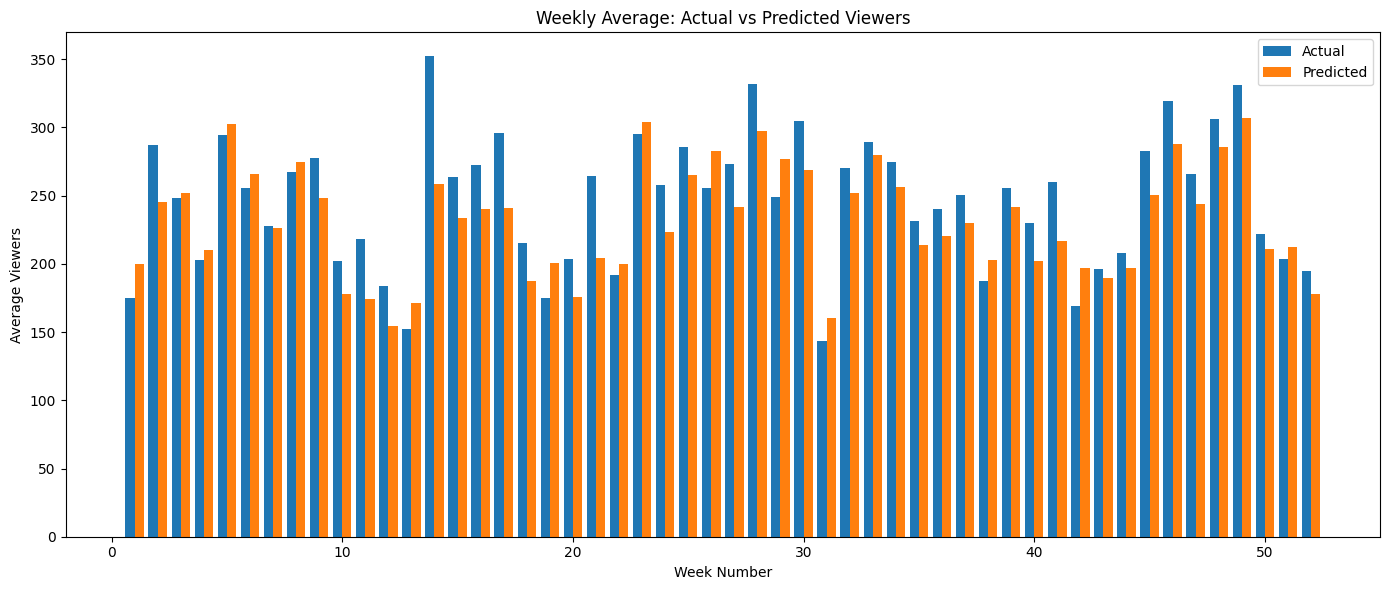

In [5]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Upload CSV
from google.colab import files
uploaded = files.upload()

# Read uploaded file
df = pd.read_csv("final_exploded_boxoffice_with_genres_and_seasons.csv")

# Feature Engineering
df['Movie_Rank'] = df.groupby(['Year', 'Week']).cumcount() + 1
holiday_weeks = list(range(1, 3)) + list(range(26, 32)) + [52]
df['IsHolidayWeek'] = df['Week'].apply(lambda x: 1 if x in holiday_weeks else 0)
df['GenreCount'] = 1
df['Log_Viewers'] = np.log1p(df['Viewers'])  # log(1 + x)

# One-hot encoding for Season and Genre
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical = df[['Season', 'Genres_List']]
encoded = encoder.fit_transform(categorical)
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Season', 'Genres_List']))

# Combine all features
numerical = df[['Week', 'Year', 'Movie_Rank', 'IsHolidayWeek', 'GenreCount']].reset_index(drop=True)
X = pd.concat([numerical, encoded_df], axis=1)
y_log = df['Log_Viewers'].reset_index(drop=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

#  Predict
y_pred_log = model.predict(X_test)

#  Inverse log transform
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

#  Evaluation
mae = mean_absolute_error(y_test_actual, y_pred)
mse = mean_squared_error(y_test_actual, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test_actual, y_pred)

print(" Model Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


# Plot: Prediction vs Actual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_actual, y=y_pred, alpha=0.5)
plt.xlabel("Actual Viewers")
plt.ylabel("Predicted Viewers")
plt.title("Predicted vs Actual Viewers")
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], '--r')
plt.tight_layout()
plt.savefig("prediction_vs_actual.png", dpi=300)
plt.show()

print(" ")
# Restore original feature info to test set for plotting
X_test_with_index = X_test.copy()
X_test_with_index["Week"] = df.loc[X_test.index, "Week"].values
X_test_with_index["Genres_List"] = df.loc[X_test.index, "Genres_List"].values



weekly_df = pd.DataFrame({

    "Week": X_test_with_index["Week"],
    "Actual": y_test_actual,
    "Predicted": y_pred
})
weekly_avg = weekly_df.groupby("Week").mean(numeric_only=True).reset_index()

plt.figure(figsize=(14, 6))
bar_width = 0.4
plt.bar(weekly_avg["Week"] - bar_width/2, weekly_avg["Actual"], width=bar_width, label="Actual")
plt.bar(weekly_avg["Week"] + bar_width/2, weekly_avg["Predicted"], width=bar_width, label="Predicted")
plt.xlabel("Week Number")
plt.ylabel("Average Viewers")
plt.title("Weekly Average: Actual vs Predicted Viewers")
plt.legend()
plt.tight_layout()
plt.savefig("bar_weekly_avg_actual_vs_predicted.png", dpi=300)
plt.show()

